In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy import stats
from sklearn.metrics import roc_curve, auc
from scipy.stats import ttest_ind

In [136]:
data = pd.read_csv('Fraud_Detection_Dataset.csv')

In [137]:
data.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [138]:
data.describe()

,Transaction ID,Customer ID,Transaction Amount,Previous Transaction Amount,Time Since Last Transaction
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,559.865608,461.410984,677.040726
std,2886.89568,1152.371939,399.984400,334.582413,432.386769
min,1.00000,1000.000000,1.000000,0.000000,1.000000
25%,2500.75000,2001.750000,262.969956,181.109688,295.523894
50%,5000.50000,3004.000000,522.370941,404.367010,653.143168
75%,7500.25000,4010.000000,788.415931,676.079655,1048.479972
max,10000.00000,4999.000000,2953.394492,1500.000000,1694.715674


In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


In [140]:
# Search for all attributes that may be dates
date_columns = [col for col in data.columns if data[col].astype(str).str.contains(r'\b\d{4}[-/]\d{2}[-/]\d{2}\b', na=False).any()]
# Convert date-formatted columns to datetime types
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')
# Print the converted data type

print(data.dtypes)

Transaction ID                          int64
Customer ID                             int64
Transaction Amount                    float64
Transaction Date and Time      datetime64[ns]
Merchant Category                      object
Location                               object
Previous Transaction Amount           float64
Time Since Last Transaction           float64
Device Type                            object
Fraud                                  object
dtype: object


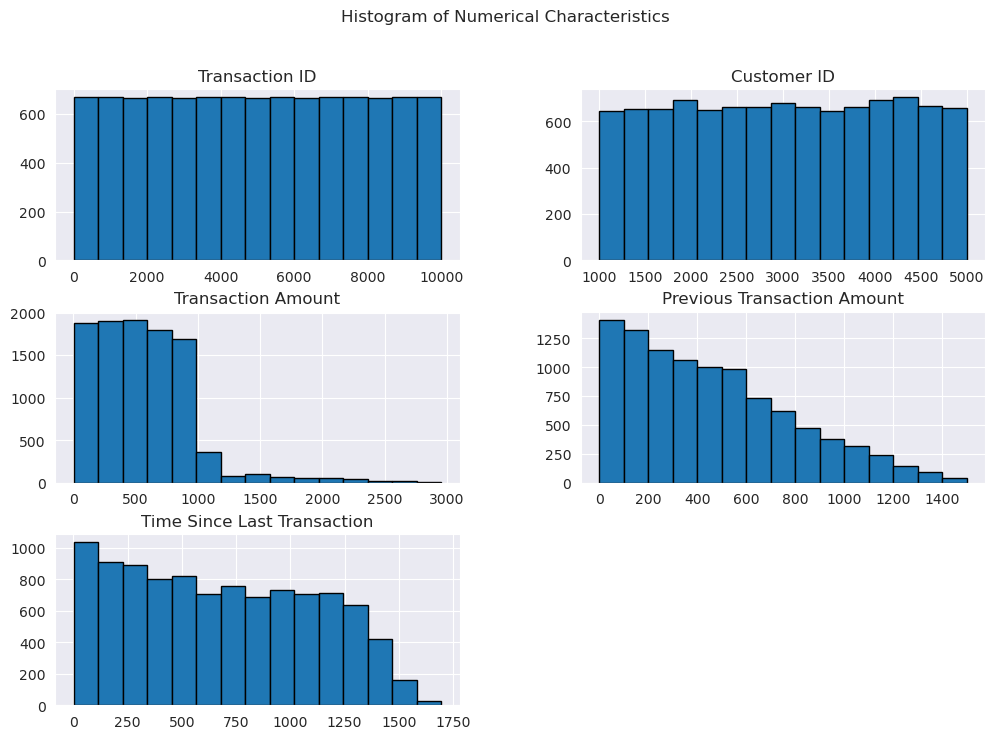

In [141]:
# Select numerical columns from the data
num_features = data.select_dtypes(include=[np.number]).columns
# Plot histograms for each numerical feature
data[num_features].hist(figsize=(12, 8), bins=15, edgecolor='black')
# Set the overall title for the plot
plt.suptitle('Histogram of Numerical Characteristics')
# Display the plot
plt.show()


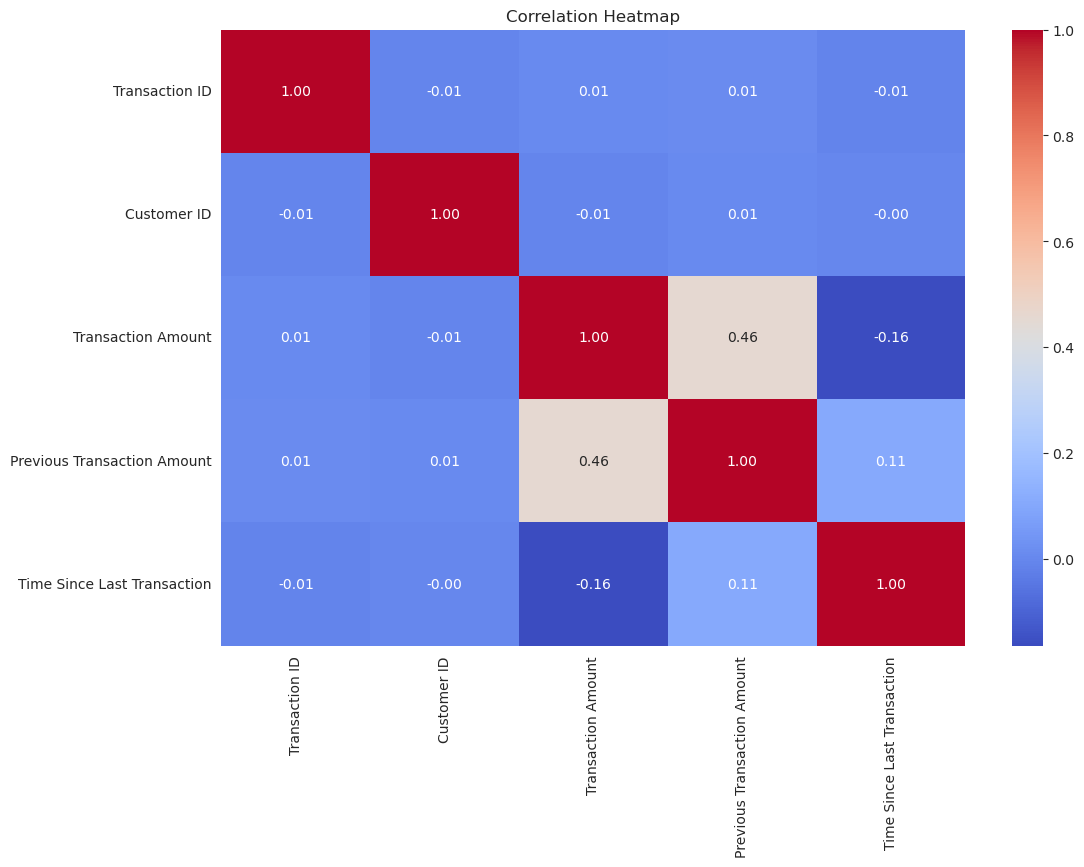

In [142]:
# Select numerical columns from the data
num_features = data.select_dtypes(include=[np.number])
# Calculate the correlation matrix for numerical features
correlation = num_features.corr()
# Create a figure for the heatmap
plt.figure(figsize=(12, 8))
# Plot the correlation matrix as a heatmap
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
# Set the title for the heatmap
plt.title('Correlation Heatmap')
# Display the plot
plt.show()


/tmp/ipykernel_9233/1077391782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[col], palette='viridis')
/tmp/ipykernel_9233/1077391782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[col], palette='viridis')
/tmp/ipykernel_9233/1077391782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[col], palette='viridis')
/tmp/ipykernel_9233/1077391782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=F

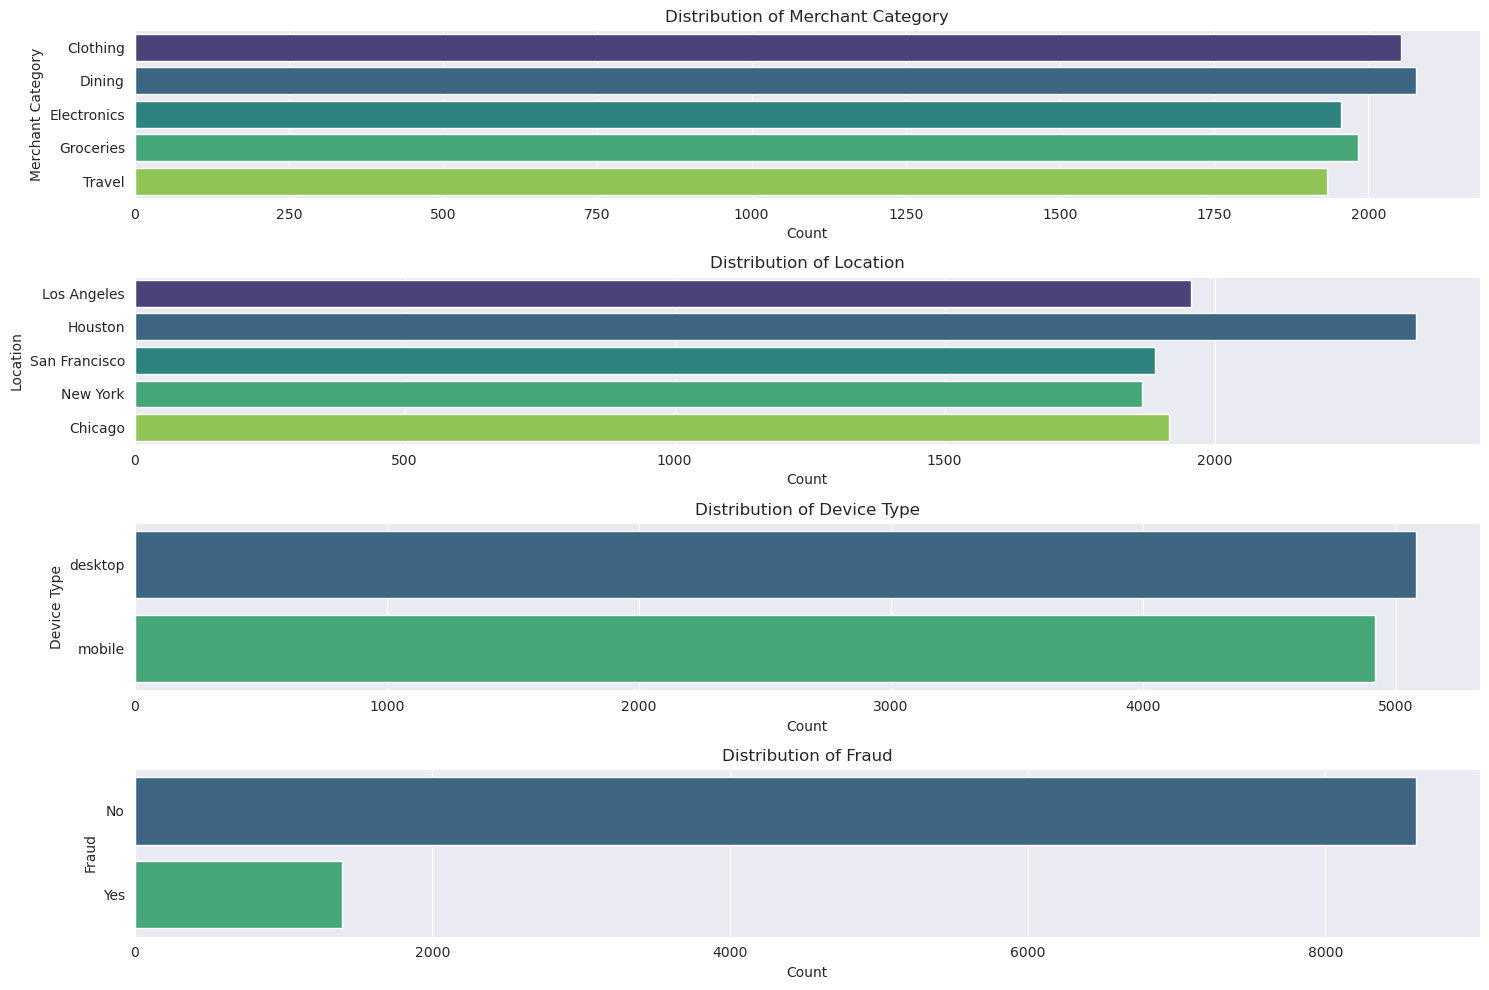

In [143]:
# Plotting distributions of non-numeric (categorical) attributes
object_columns = data.select_dtypes(include=['object']).columns
# Create a figure for the plots
plt.figure(figsize=(15, 10))
# Iterate over the categorical columns and create a subplot for each
for i, col in enumerate(object_columns):
    # Create a subplot for the current column
    plt.subplot(len(object_columns), 1, i + 1)
    # Plot the count distribution of the current column
    sns.countplot(y=data[col], palette='viridis')
    # Set the title and labels for the subplot
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
# Adjust layout to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()


<Axes: ylabel='Time Since Last Transaction'>

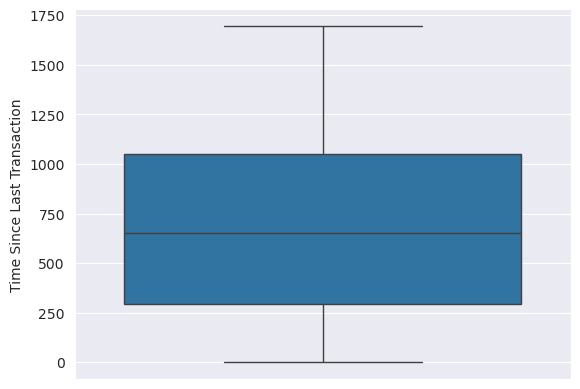

In [144]:
sns.boxplot(data['Time Since Last Transaction'])


<Axes: xlabel='Location'>

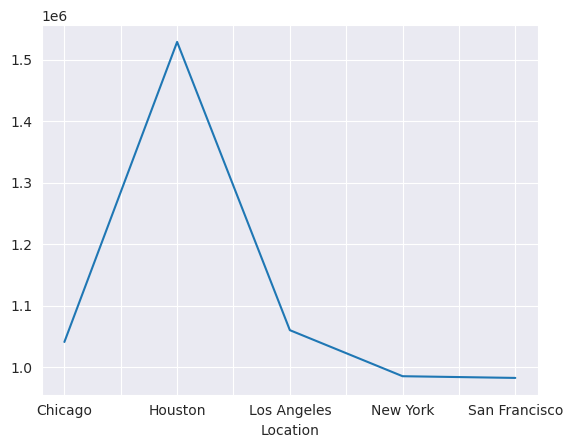

In [145]:
data.groupby('Location')['Transaction Amount'].sum().sort_index().plot()

<Axes: xlabel='Customer ID'>

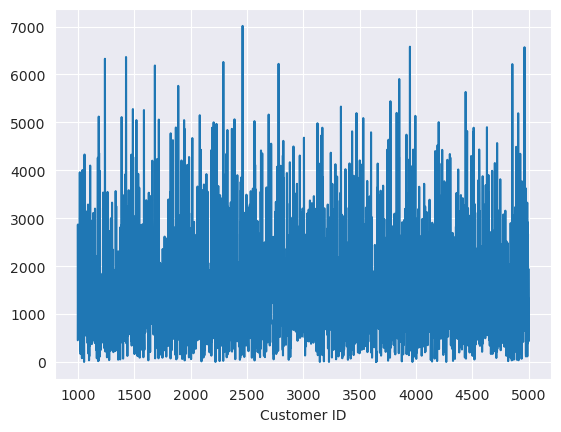

In [146]:
data.groupby('Customer ID')['Transaction Amount'].sum().sort_index().plot()

<Axes: xlabel='Customer ID'>

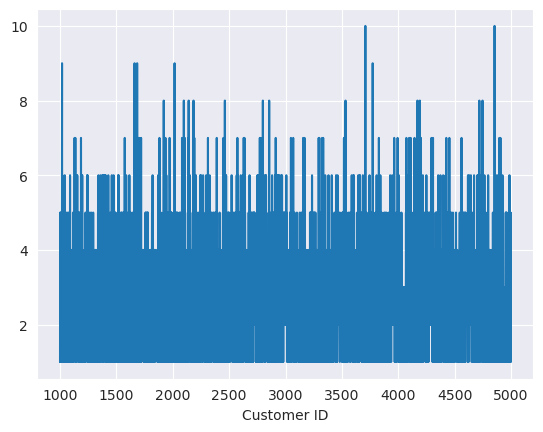

In [147]:
data.groupby('Customer ID')['Transaction ID'].count().sort_index().plot()

In [148]:
# Sort the data by Customer ID and Transaction Date and Time
data = data.sort_values(by=['Customer ID', 'Transaction Date and Time'])
# Calculate cumulative transaction amount and count for each record
data['Cumulative Transaction Amount'] = data.groupby('Customer ID')['Transaction Amount'].cumsum()
data['Cumulative Transaction Count'] = data.groupby('Customer ID').cumcount() + 1
# Calculate cumulative average transaction amount
data['Cumulative Average Transaction Amount'] = data['Cumulative Transaction Amount'] / data['Cumulative Transaction Count']
# Drop unnecessary columns
data.drop(columns=['Transaction ID', 'Transaction Date and Time'], inplace=True)
# Display the first few rows of the processed dataframe
data.head()


,Customer ID,Transaction Amount,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,Cumulative Transaction Amount,Cumulative Transaction Count,Cumulative Average Transaction Amount
4523,1000,453.146856,Dining,Los Angeles,506.895210,973.877451,desktop,No,453.146856,1,453.146856
288,1001,516.045443,Electronics,Houston,75.228658,411.148237,mobile,Yes,516.045443,1,516.045443
2508,1001,748.587045,Electronics,Chicago,544.524195,1232.044088,desktop,No,1264.632487,2,632.316244
2674,1001,1432.893007,Groceries,Houston,52.041595,137.106905,mobile,Yes,2697.525494,3,899.175165
2988,1001,1.000000,Dining,Houston,31.656963,529.618852,mobile,No,2698.525494,4,674.631374


<Axes: xlabel='Merchant Category'>

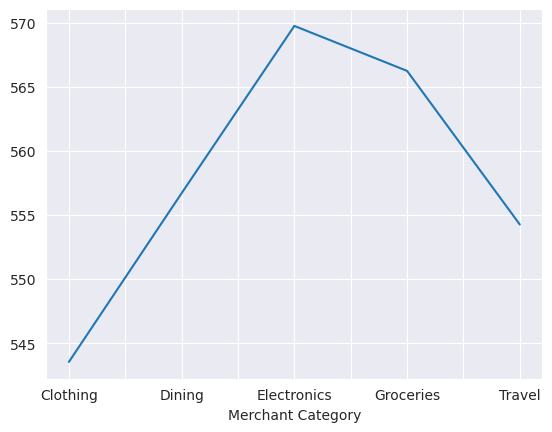

In [149]:
data.groupby('Merchant Category')['Cumulative Average Transaction Amount'].mean().sort_index().plot()

<Axes: xlabel='Fraud', ylabel='Cumulative Average Transaction Amount'>

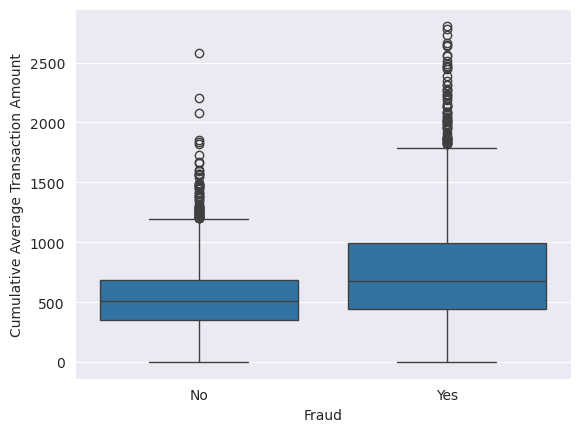

In [150]:
sns.boxplot(x='Fraud', y='Cumulative Average Transaction Amount', data=data)


(array([2077.,    0., 1955.,    0.,    0., 1983.,    0., 1933.,    0.,
        2052.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

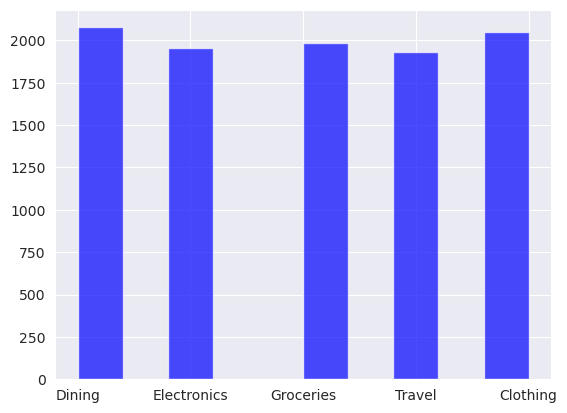

In [151]:
plt.hist(data['Merchant Category'], alpha=0.7, color='blue')

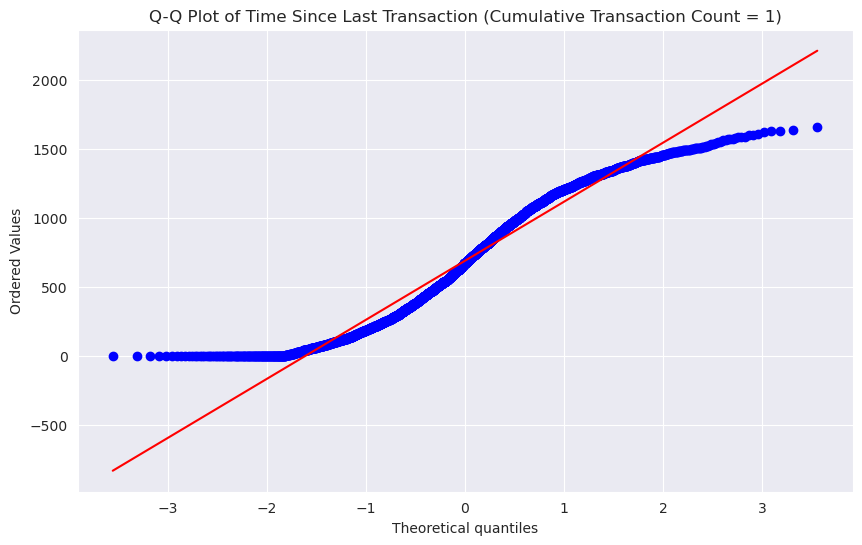

In [152]:
filtered_data = data[data['Cumulative Transaction Count'] == 1]

plt.figure(figsize=(10, 6))
stats.probplot(filtered_data['Time Since Last Transaction'], dist='norm', plot=plt)
plt.title('Q-Q Plot of Time Since Last Transaction (Cumulative Transaction Count = 1)')
plt.show()

<Axes: xlabel='Merchant Category'>

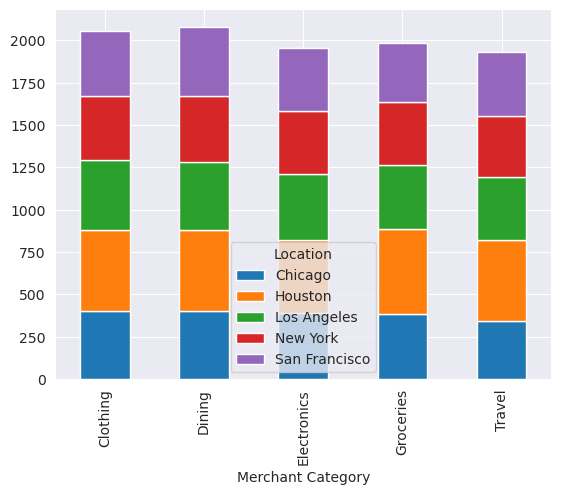

In [153]:
data.groupby(['Merchant Category', 'Location'])['Cumulative Average Transaction Amount'].count().unstack().plot(kind='bar', stacked=True)


/tmp/ipykernel_9233/3935183358.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Merchant Category', y='Cumulative Average Transaction Amount', data=data, ax=ax1, palette='tab10')
/tmp/ipykernel_9233/3935183358.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Merchant Category', y='Cumulative Transaction Amount', data=data, ax=ax2, palette='tab10')
/tmp/ipykernel_9233/3935183358.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Merchant Category', y='Cumulative Transaction Count', data=data, ax=ax3, palette='tab10')
/tmp/ipyk

<Axes: xlabel='Merchant Category', ylabel='Transaction Amount'>

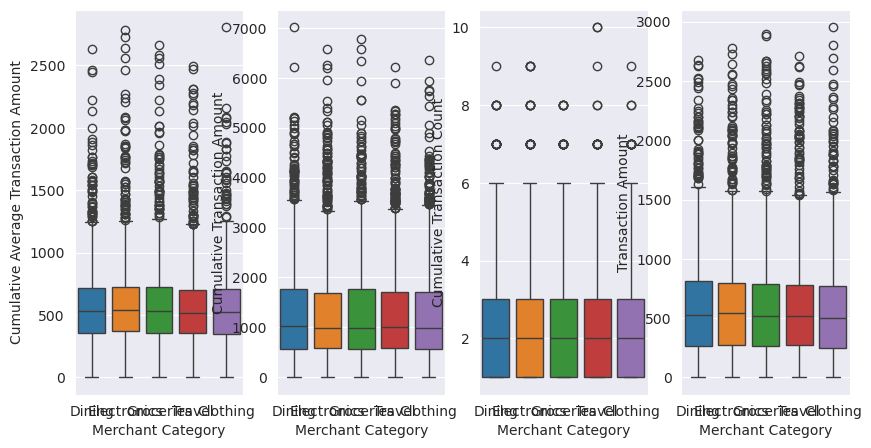

In [154]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
sns.boxplot(x='Merchant Category', y='Cumulative Average Transaction Amount', data=data, ax=ax1, palette='tab10')

sns.boxplot(x='Merchant Category', y='Cumulative Transaction Amount', data=data, ax=ax2, palette='tab10')

sns.boxplot(x='Merchant Category', y='Cumulative Transaction Count', data=data, ax=ax3, palette='tab10')

sns.boxplot(x='Merchant Category', y='Transaction Amount', data=data, ax=ax4, palette='tab10')


<Axes: xlabel='Merchant Category', ylabel='Cumulative Average Transaction Amount'>

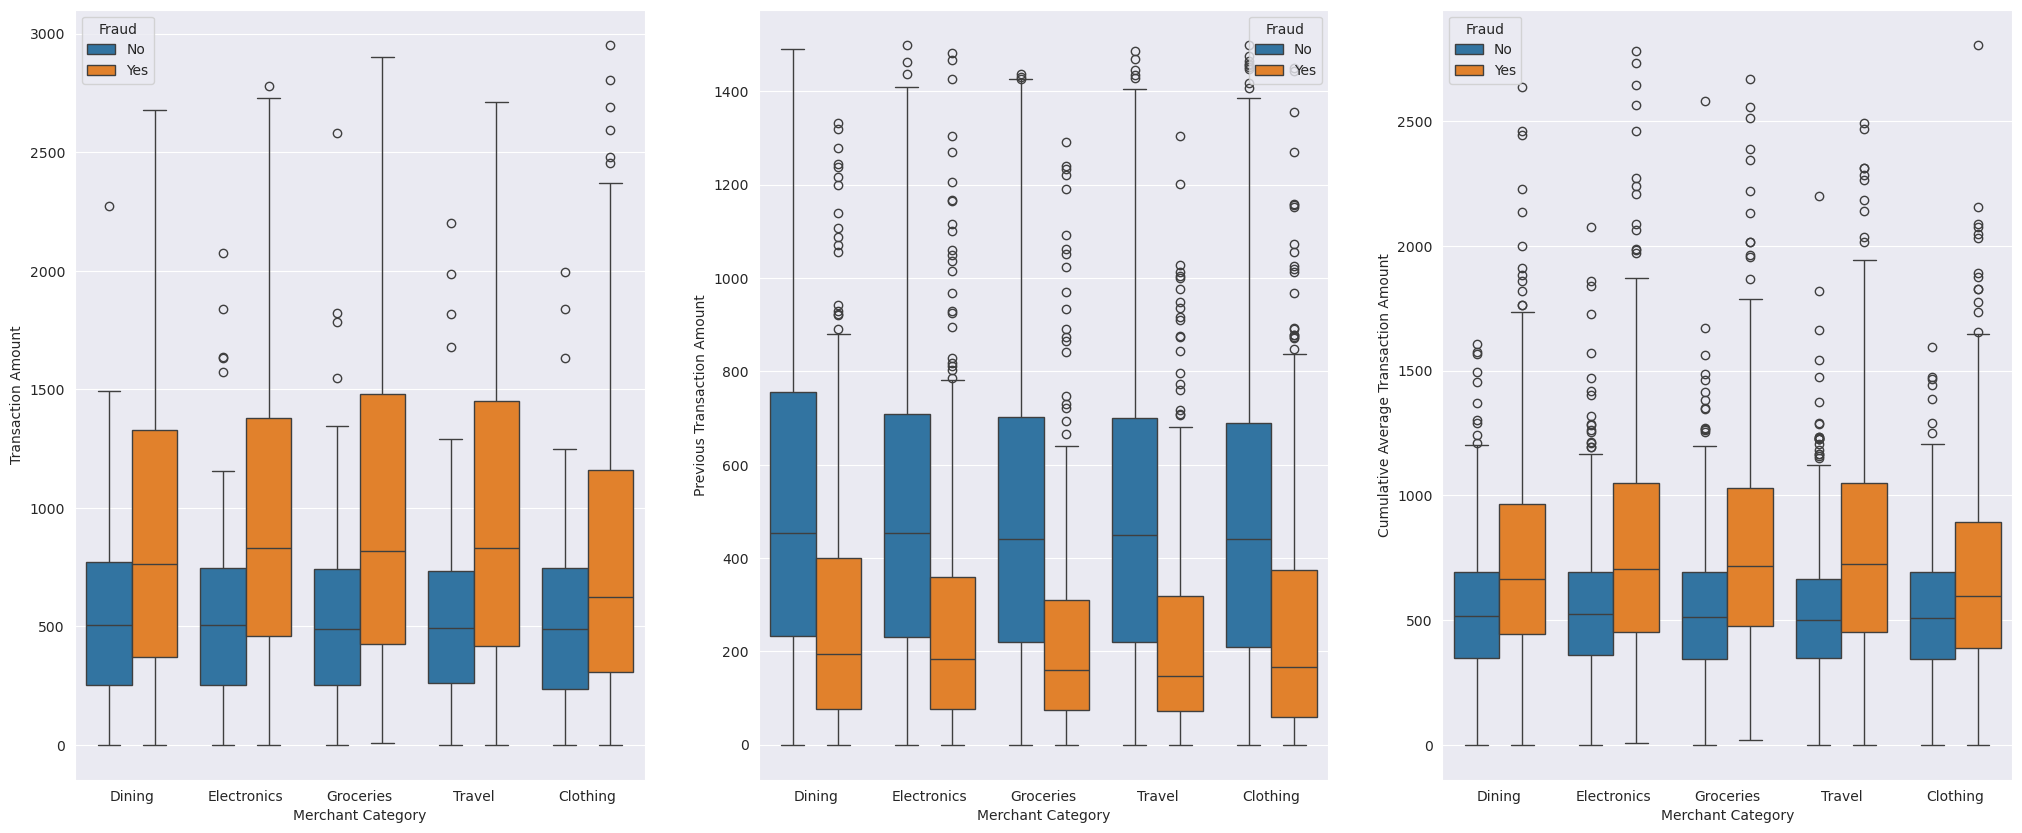

In [155]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
sns.boxplot(x='Merchant Category', y='Transaction Amount', hue='Fraud', data=data, ax=ax1, palette='tab10')
sns.boxplot(x='Merchant Category', y='Previous Transaction Amount', hue='Fraud', data=data, ax=ax2, palette='tab10')
sns.boxplot(x='Merchant Category', y='Cumulative Average Transaction Amount', hue='Fraud', data=data, ax=ax3, palette='tab10')


In [156]:
left_employees = data[data['Fraud'] == 'Yes']
stayed_employees = data[data['Fraud'] == 'No']
numerical_cols = data.select_dtypes(include='number').columns
ttest_results = {}
for col in numerical_cols:
    t_stat, p_value = ttest_ind(left_employees[col], stayed_employees[col], nan_policy='omit')
    ttest_results[col] = {'t_stat': t_stat, 'p_value': p_value}
# Convert results to DataFrame for better readability
ttest_results_df = pd.DataFrame(ttest_results).T
ttest_results_df

,t_stat,p_value
Customer ID,-0.911903,3.618420e-01
Transaction Amount,38.693807,2.431545e-305
Previous Transaction Amount,-24.375418,1.565505e-127
Time Since Last Transaction,-27.816018,4.403835e-164
Cumulative Transaction Amount,16.059482,2.549295e-57
Cumulative Transaction Count,0.265087,7.909478e-01
Cumulative Average Transaction Amount,29.802029,4.726550e-187


In [157]:
X, y = data.drop(columns=['Fraud', 'Customer ID']), data['Fraud']
y = y.map({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [158]:
# Select columns with categorical data
categorical_features = X.select_dtypes(include=['object']).columns

# Define a pipeline for transforming categorical features
categorical_transformer = Pipeline(steps=[
    # Apply one-hot encoding to handle categorical features
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [159]:
# Select columns with numerical data
numerical_features = X.select_dtypes(include=['number']).columns
# Define a pipeline for transforming numerical features
numerical_transformer = Pipeline(steps=[
    # Apply standard scaling to normalize numerical features
    ('scaler', StandardScaler())
])


In [160]:
# Combine numerical and categorical transformers into a single preprocessor
preprocessor = ColumnTransformer(transformers=[
    # Apply the numerical transformer to numerical features
    ('num', numerical_transformer, numerical_features),
    # Apply the categorical transformer to categorical features
    ('cat', categorical_transformer, categorical_features)
])

In [161]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_features': ['sqrt', 'log2'],
            'classifier__max_depth': [None, 10, 20, 30]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'Support Vector Machine': {

        'model': SVC(probability=True),
        'params': {

            'classifier__C': [0.1, 1, 10, 100],
            # 'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            # 'classifier__gamma': ['scale', 'auto']
        }
    }
}

In [162]:
# Initialize a dictionary to store the best models
best_models = {}
# Define a list of evaluation metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Initialize a dictionary to store the results for each metric
results = {metric: [] for metric in metrics}
# Initialize a list to store the names of the models
model_names = []

In [163]:
for name, model_params in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_params['model'])])
    param_grid = model_params['params']
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='f1')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    y_pred = grid_search.predict(X_test)
    # Store the model name
    model_names.append(name)
    # Calculate and store indicators
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['precision'].append(precision_score(y_test, y_pred, average='macro'))
    results['recall'].append(recall_score(y_test, y_pred, average='macro'))
    results['f1'].append(f1_score(y_test, y_pred, average='macro'))
    print(f'Best parameters for {name}: {grid_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters for KNN: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Naive Bayes: {'classifier__var_smoothing': 1e-09}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Be

In [164]:
df = pd.DataFrame(results, index=model_names)
df

,accuracy,precision,recall,f1
Logistic Regression,0.923000,0.943505,0.739378,0.799907
KNN,0.912667,0.897405,0.722752,0.775791
Naive Bayes,0.891667,0.803614,0.703747,0.738814
Random Forest,0.938333,0.947697,0.796469,0.850590
Decision Tree,0.931667,0.927279,0.782948,0.834437
Support Vector Machine,0.936667,0.940352,0.794533,0.847119


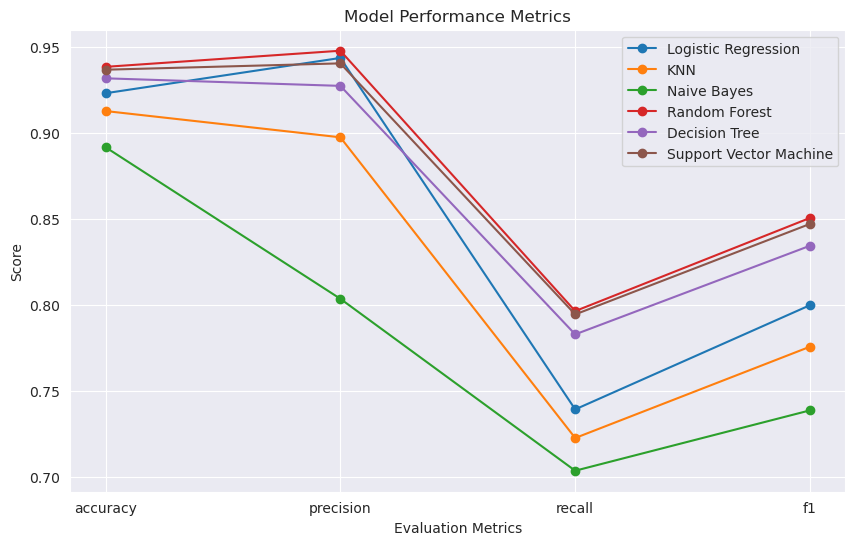

In [165]:
# Convert the results dictionary to a DataFrame
results_data = pd.DataFrame(results, index=model_names)
# Transpose the DataFrame so that models are columns and metrics are rows
results_data_transposed = results_data.T
# Plot results
plt.figure(figsize=(10, 6))
for model in results_data_transposed.columns:
    plt.plot(results_data_transposed.index, results_data_transposed[model], marker='o', label=model)
plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

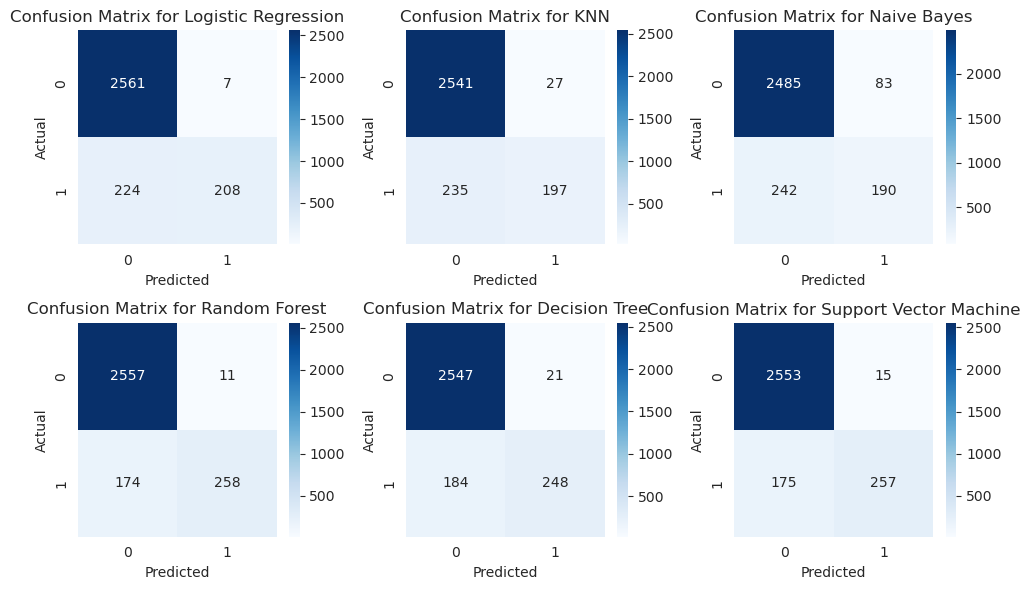

In [166]:
# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()
# Iterate over the axes and the best models
for ax, (name, model) in zip(axes, best_models.items()):
    # Predict the target values using the model
    y_pred = model.predict(X_test)
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    # Set the title and labels for the subplot
    ax.set_title(f'Confusion Matrix for {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
# Adjust layout to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()


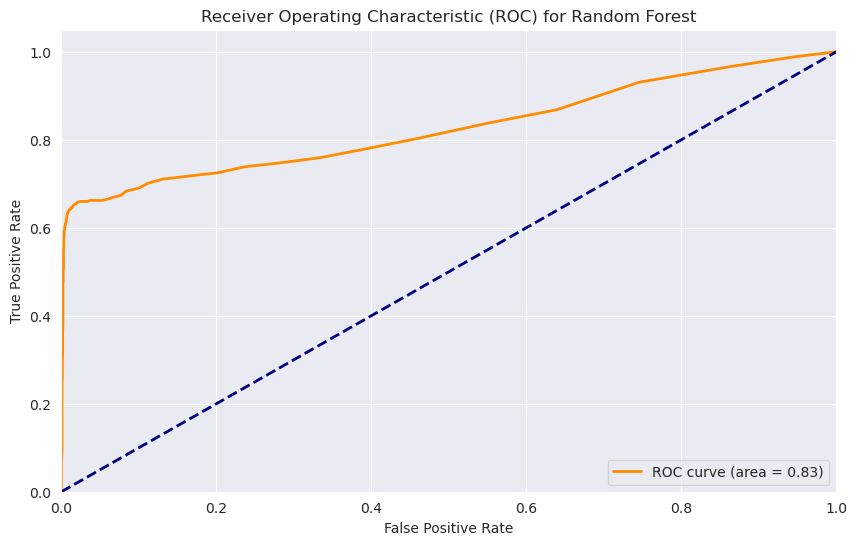

The best model is: Random Forest with an AUC of 0.83


In [167]:
best_model_index = results['f1'].index(max(results['f1']))
best_model_name = model_names[best_model_index]
best_model = best_models[best_model_name]
# Predicted probability
y_prob = best_model.predict_proba(X_test)[:, 1]
# Calculate ROC curves and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
# Plotting ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) for {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print(f'The best model is: {best_model_name} with an AUC of {roc_auc:.2f}')
